### G5 Class Activation Map

- 학습 목표 
    - Classification model로부터 CAM을 얻어낼 수 있다. 
    - CAM으로 물체의 위치를 찾을 수 있다. 
    - CAM을 시각화 비교할 수 있다. 

In [64]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image
import urllib3

In [65]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 1. 데이터 로드

In [66]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    )

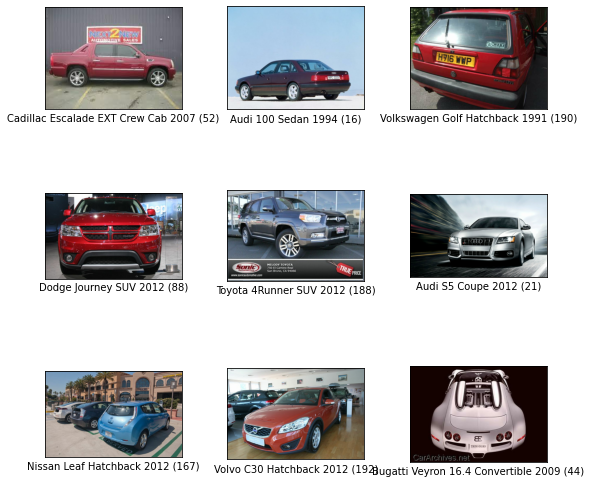

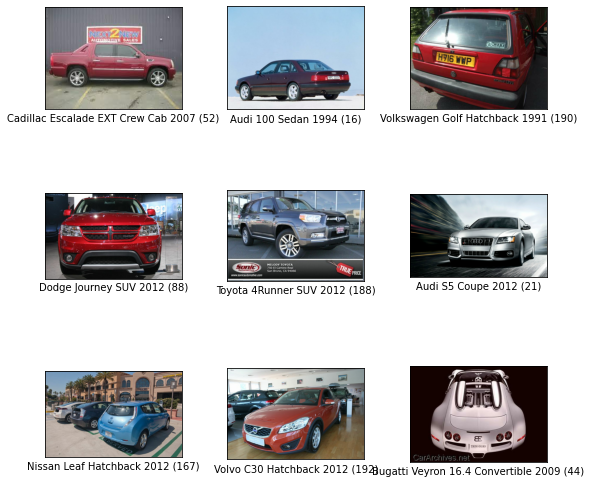

In [67]:
tfds.show_examples(ds_train, ds_info)

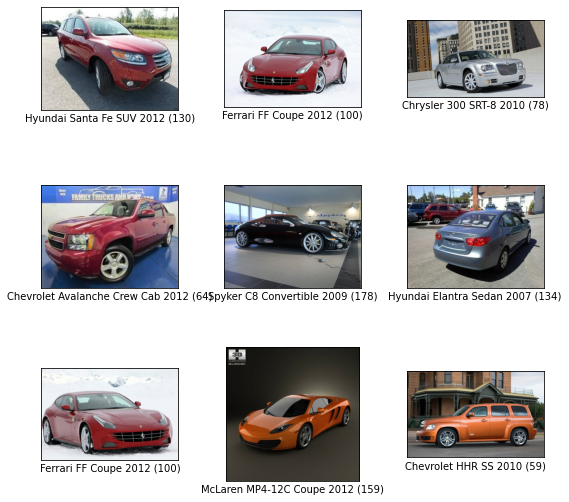

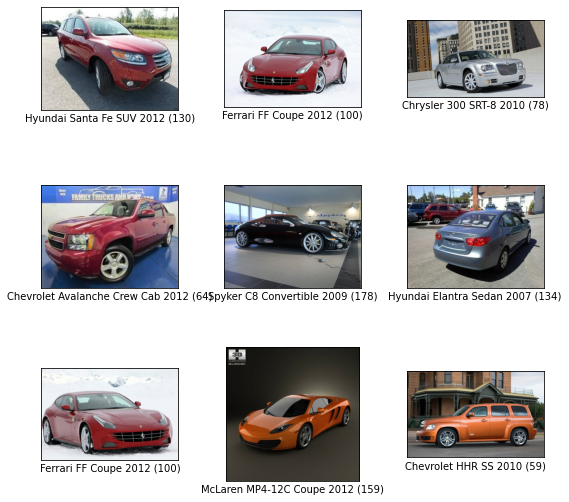

In [68]:
tfds.show_examples(ds_test, ds_info)

In [69]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

#### 2. 모델 불러오기
- ResNet50

In [70]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False, 
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)

cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [71]:
cam_model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [72]:
def normalize_and_resize_img(input):
    
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2,
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [73]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [74]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

#### 3. 모델 학습

In [75]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15, 
    validation_data=ds_test_norm, 
    verbose=1, 
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 81s 160ms/step - loss: 4.1622 - accuracy: 0.1582 - val_loss: 5.4607 - val_accuracy: 0.0108
Epoch 2/15
509/509 [==============================] - 80s 158ms/step - loss: 1.6909 - accuracy: 0.6233 - val_loss: 1.9584 - val_accuracy: 0.4973
Epoch 3/15
509/509 [==============================] - 80s 158ms/step - loss: 0.6106 - accuracy: 0.8894 - val_loss: 1.2964 - val_accuracy: 0.6679
Epoch 4/15
509/509 [==============================] - 80s 157ms/step - loss: 0.1866 - accuracy: 0.9808 - val_loss: 1.0850 - val_accuracy: 0.7082
Epoch 5/15
509/509 [==============================] - 80s 158ms/step - loss: 0.0636 - accuracy: 0.9969 - val_loss: 1.0375 - val_accuracy: 0.7242
Epoch 6/15
509/509 [==============================] - 80s 158ms/step - loss: 0.0369 - accuracy: 0.9984 - val_loss: 1.0187 - val_accuracy: 0.7245
Epoch 7/15
509/509 [==============================] - 80s 158ms/step - loss: 0.0259 - accuracy: 0.9986 - val_loss: 0.9933 - val_ac

In [76]:
import os 

cam_model_path = os.getenv('HOME') + ('/aiffel/class_activation_map/cam_model.h5')
cam_model.save(cam_model_path)

In [77]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

#### 4. CAM 구현

141


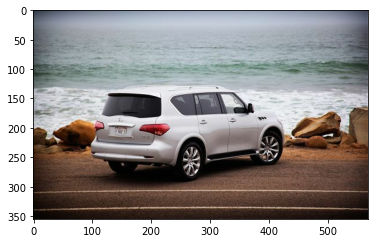

In [158]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [159]:
cam_model = tf.keras.models.load_model(cam_model_path)

In [160]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        
        cam_image += w * conv_outputs[:, :, i]
        
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

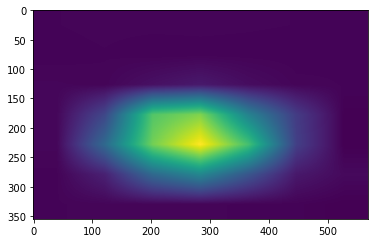

In [161]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [162]:
def visualize_cam_on_image(src1, src2, alpha=0.8):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

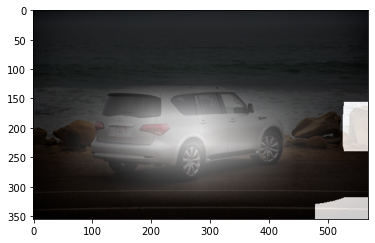

In [163]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

#### 5. Grad-CAM 구현

43


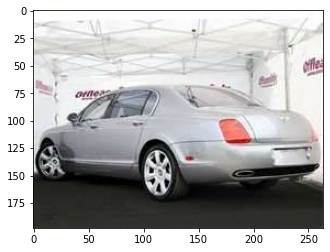

In [164]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [165]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]
        
    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

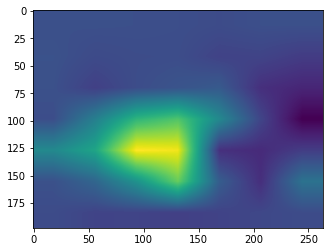

In [166]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

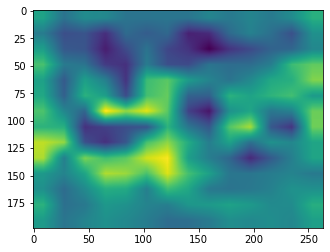

In [168]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

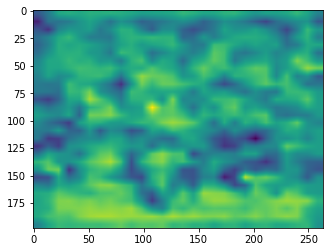

In [169]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

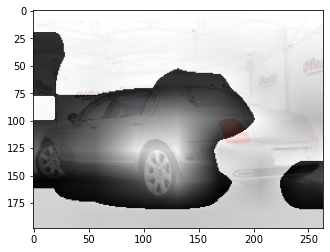

In [167]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

#### 6. 바운딩 박스 구하기

141


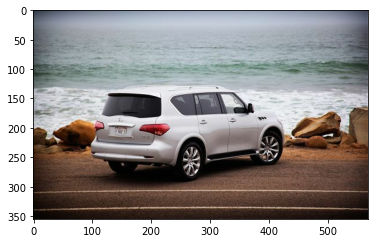

In [170]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

- CAM

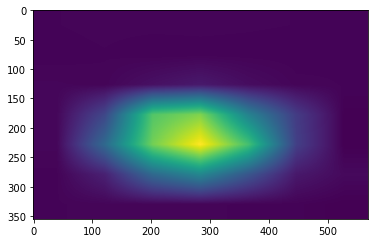

In [171]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

- Grad_CAM

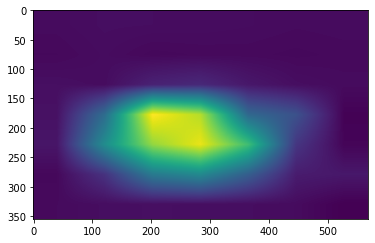

In [172]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out',item)
plt.imshow(grad_cam_image)

In [173]:
def get_bbox(cam_image, score_thresh= 0.05):
    
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image * 255).astype(np.uint8)
    
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    
    return rect

In [174]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[502, 324],
       [ 51, 324],
       [ 51, 119],
       [502, 119]])

In [175]:
grad_image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[504, 324],
       [ 45, 324],
       [ 45, 106],
       [504, 106]])

- CAM 바운딩 박스

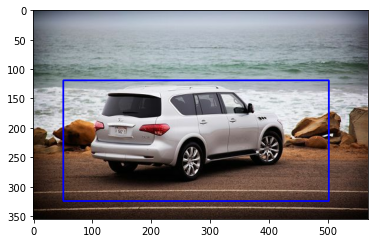

In [176]:
image = cv2.drawContours(image,[rect], 0, (0,0,255), 2)
plt.imshow(image)

- Grad-CAM 바운딩 박스

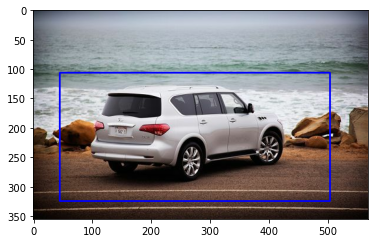

In [177]:
grad_image = cv2.drawContours(grad_image,[grad_rect], 0, (0,0,255), 2)
plt.imshow(grad_image)

In [178]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:, 1].min()/float(image.shape[0]),
        rect[:, 0].min()/float(image.shape[1]),
        rect[:, 1].max()/float(image.shape[0]),
        rect[:, 0].max()/float(image.shape[1]),
        
    ]
    return bbox

In [179]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.3352112676056338,
 0.08963093145869948,
 0.9126760563380282,
 0.8822495606326889]

In [180]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.29859154929577464,
 0.07908611599297012,
 0.9126760563380282,
 0.8857644991212654]

In [181]:
item['bbox']

array([0.35211268, 0.16695958, 0.8197183 , 0.7557118 ], dtype=float32)

In [182]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max-y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea +  boxBArea - interArea)
    
    return iou

- CAM IOU

In [183]:
get_iou(pred_bbox, item['bbox'])

0.6014817942730263

- Grad-CAM IOU

In [184]:
get_iou(grad_pred_bbox, item['bbox'])

0.5557554245319165

#### 7. 고찰
- CAM을 통해 모델이 분류를 위해 중점적으로 보는 부분이 어디인지를 시각화해보면서 모델의 학습방법을 이해하는데 도움이 되었다. 
- 바운딩 박스를 이용하면 Object Detection을 위해 만들어진 학습데이터가 아니어도 분류 데이터로도 Object Detection이 가능하여서 데이터가 부족한 상황에 활용도가 높을것이라고 생각된다. 
- Grad-CAM의 결과를 보면 레이어층이 깊어질수록 자동차가 위치한 곳을 보고 있는 것을 알 수 있다. 이것을 보면 모델의 학습 레이어를 깊게 쌓을수록 더 정확도가 높아지는 것을 설명할 수 있을 것으로 생각된다. 